<a href="https://colab.research.google.com/github/tinumide/cuda-python-examples/blob/main/mandelbrot_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mandelbrot Set

This example generates an image of the Mandelbrot fractal using the numba library to accelerate the calculations with GPU computing. The Mandelbrot set is the set of complex numbers `c` for which the function `f(zn+1) = zn**2 + c` does not become unstable when iterated from `z0 = 0`.
The fractal is typically visualized by coloring the points in the complex plane according to the number of iterations it takes to become unstable or reach a maximum number of iterations.

The main components of the code are:

1. A `mandelbrot` function that takes a complex number `c` as input and returns the number of iterations it took for the Mandelbrot sequence to become stable or unstable.
2. A `mandelbrot_kernel` function, which is a CUDA kernel, that generates the Mandelbrot set image by computing the Mandelbrot iteration count for each pixel (i.e., complex value `c`).

In [ ]:
import numba
import numpy as np
from numba import cuda
from pylab import imshow, show
from timeit import default_timer as timer

In [ ]:
def mandelbrot(c):
  """
  Calculate the Mandelbrot iteration count for a given complex number (c).
    
  Takes in a complex number c and returns the number of iterations it took for the function
  f(zn+1) = zn**2 + c to become stable or unstable.

  Parameters:
  c (complex): The complex number to evaluate.

  Returns:
  iter (int): The number of iterations taken.
  """
  MAX_ITER = 80
  iter = 0
  z = 0.0j

  while abs(z) <= 2 and iter < MAX_ITER:
    z = z*z + c
    iter += 1
  return iter 

In [ ]:
@cuda.jit
def mandelbrot_kernel(image):
  """
  CUDA kernel for generating the Mandelbrot set image.

  Determines if each pixel (i.e. c value) belongs to the Mandelbrot set and fills the image.

  Parameters:
  image (numpy.ndarray): The image array to be filled with the Mandelbrot set data.
  """
  height = image.shape[0]
  width = image.shape[1]

  #real axis range
  re_start = -2.0
  re_end = 1.0
  #imaginary axis range
  i_start = -1.0
  i_end = 1.0

  x_pixel_size = (re_end - re_start)/width
  y_pixel_size = (i_end - i_start)/height

  x_idx, y_idx = cuda.grid(2)
  
  re = re_start + x_idx * x_pixel_size
  i = i_start + y_idx * y_pixel_size 
  c = complex(re, i)
  image[y_idx, x_idx] = mandelbrot_gpu(c)

  

  


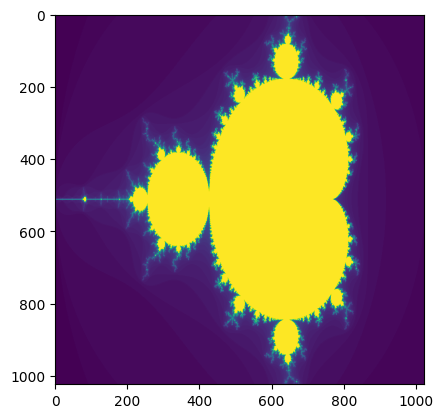

In [ ]:
# Create an empty image of size 1024x1024 with datatype uint8
image = np.zeros((1024, 1024), dtype = np.uint8)

# Transfer the image data to the GPU
d_image = cuda.to_device(image)

# Define the number of threads per block and the block dimensions
threads_per_block = (256, 256)
blockdim = (4, 4)

# Compile the mandelbrot function for GPU
mandelbrot_gpu = cuda.jit(device=True)(mandelbrot)

# Execute the kernel on the GPU
mandelbrot_kernel[threads_per_block, blockdim](d_image)

# Copy the Mandelbrot set image from the GPU back to the host
mandelbrot_set_image = d_image.copy_to_host()

# Display the Mandelbrot set image
imshow(mandelbrot_set_image)
show()